# CSV Clean & EDA

Load all CSVs from `data/`, remove duplicates, run EDA, and save cleaned files as `*_cleaned.csv` in `data/`.

In [1]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data")
OUT_SUFFIX = "_cleaned"

csv_files = sorted(DATA_DIR.glob("*.csv"))
csv_files = [f for f in csv_files if not f.name.endswith(f"{OUT_SUFFIX}.csv")]
print(f"Found {len(csv_files)} CSV files:", [f.name for f in csv_files])

Found 5 CSV files: ['buildings.csv', 'contractors.csv', 'energy_consumption.csv', 'financial_profiles.csv', 'retrofit_measures.csv']


## 1. Load, drop duplicates, and summarize

In [2]:
results = []
dfs_cleaned = {}

for fp in csv_files:
    name = fp.stem
    df = pd.read_csv(fp)
    n_before = len(df)
    n_dup_rows = df.duplicated().sum()
    df_no_dup_rows = df.drop_duplicates()
    n_after_rows = len(df_no_dup_rows)
    
    id_col = None
    for c in ["building_id", "measure_id", "contractor_id", "consumption_id", "profile_id"]:
        if c in df.columns:
            id_col = c
            break
    
    if id_col:
        n_dup_id = df_no_dup_rows.duplicated(subset=[id_col]).sum()
        df_cleaned = df_no_dup_rows.drop_duplicates(subset=[id_col], keep="first")
    else:
        n_dup_id = 0
        df_cleaned = df_no_dup_rows
    
    n_after = len(df_cleaned)
    # buildings: split address into street and house_num (e.g. "Landsberger Allee 36" -> street, house_num)
    if name == "buildings" and "address" in df_cleaned.columns:
        parts = df_cleaned["address"].astype(str).str.rsplit(n=1, expand=True)
        df_cleaned["street"] = parts[0].fillna("")
        df_cleaned["house_num"] = parts[1].fillna("") if parts.shape[1] >= 2 else ""
        pos = df_cleaned.columns.get_loc("address") + 1
        df_cleaned.insert(pos, "street", df_cleaned.pop("street"))
        df_cleaned.insert(pos + 1, "house_num", df_cleaned.pop("house_num"))
    dfs_cleaned[name] = df_cleaned
    results.append({
        "file": fp.name,
        "rows_before": n_before,
        "dup_rows": n_dup_rows,
        "dup_by_id": n_dup_id if id_col else "-",
        "rows_after": n_after,
        "id_col": id_col or "-",
    })

dup_summary = pd.DataFrame(results)
dup_summary

,file,rows_before,dup_rows,dup_by_id,rows_after,id_col
0,buildings.csv,10000,0,0,10000,building_id
1,contractors.csv,20,0,0,20,contractor_id
2,energy_consumption.csv,120000,0,110000,10000,building_id
3,financial_profiles.csv,10000,0,0,10000,building_id
4,retrofit_measures.csv,25,0,0,25,measure_id


## 2. EDA: shape, dtypes, nulls

In [3]:
for name, df in dfs_cleaned.items():
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Dtypes:\n{df.dtypes}")
    nulls = df.isnull().sum()
    if nulls.any():
        print(f"Nulls:\n{nulls[nulls > 0]}")
    else:
        print("Nulls: none")


=== buildings ===
Shape: (10000, 27)
Dtypes:
building_id                   object
district                      object
postal_code                    int64
address                       object
street                        object
house_num                     object
latitude                     float64
longitude                    float64
construction_year              int64
building_type                 object
num_units                      int64
total_area_m2                float64
num_floors                     int64
roof_type                     object
facade_material               object
window_type                   object
heating_system                object
heating_age                    int64
insulation_walls              object
insulation_roof               object
insulation_basement           object
ownership_type                object
epc_rating                    object
epc_date                      object
energy_consumption_kwh_m2    float64
last_renovation_year         

## 3. EDA: numeric summary

In [4]:
for name, df in dfs_cleaned.items():
    numeric = df.select_dtypes(include=["number"])
    if numeric.empty:
        continue
    print(f"\n=== {name} (numeric) ===")
    display(df[numeric.columns].describe())


=== buildings (numeric) ===


,postal_code,latitude,longitude,construction_year,num_units,total_area_m2,num_floors,heating_age,energy_consumption_kwh_m2,last_renovation_year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,6485.000000
mean,12130.620300,52.511081,13.403030,1953.991500,22.575600,1856.783340,5.444400,17.95950,183.644600,2007.366076
std,1286.334107,0.038635,0.104414,40.457371,14.858511,1292.789243,2.291252,10.10903,53.916982,9.757382
min,10115.000000,52.430009,13.180065,1870.000000,2.000000,110.500000,2.000000,1.00000,45.000000,1990.000000
25%,10779.000000,52.479574,13.325413,1909.000000,11.000000,849.300000,3.000000,9.00000,154.500000,1999.000000
50%,12437.000000,52.513908,13.406655,1970.000000,20.000000,1603.550000,5.000000,18.00000,183.100000,2008.000000
75%,13158.000000,52.535111,13.476586,1985.000000,29.000000,2527.600000,7.000000,27.00000,227.700000,2016.000000
max,14195.000000,52.599875,13.609688,2010.000000,60.000000,6568.700000,9.000000,35.00000,325.300000,2023.000000



=== contractors (numeric) ===


,years_in_business,num_employees,avg_rating,num_reviews,avg_project_cost_eur,capacity_projects_year,current_backlog_months,insurance_amount_eur,warranty_years,reliability_score,quality_score,communication_score
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,2.000000e+01,20.000000,20.000000,20.000000,20.00000
mean,14.450000,10.600000,4.32500,68.000000,76300.000000,22.850000,7.42500,2.475000e+06,5.700000,4.220000,4.440000,4.13000
std,6.762707,5.354781,0.33541,36.608886,64202.065879,12.762094,2.94366,2.110095e+06,2.319256,0.348833,0.331504,0.32298
min,5.000000,4.000000,3.50000,22.000000,22000.000000,6.000000,3.00000,5.000000e+05,2.000000,3.300000,3.600000,3.40000
25%,8.750000,6.750000,4.17500,40.250000,37250.000000,13.500000,5.37500,1.200000e+06,5.000000,4.075000,4.300000,3.97500
50%,13.000000,9.500000,4.40000,59.000000,50000.000000,19.000000,7.00000,2.000000e+06,5.000000,4.300000,4.500000,4.20000
75%,19.250000,13.250000,4.60000,89.500000,97500.000000,31.250000,9.12500,2.850000e+06,7.000000,4.500000,4.700000,4.40000
max,28.000000,25.000000,4.80000,156.000000,285000.000000,50.000000,14.00000,1.000000e+07,12.000000,4.700000,4.900000,4.60000



=== energy_consumption (numeric) ===


,year,month,heating_kwh,electricity_kwh,total_cost_eur,heating_cost_eur,outdoor_temp_avg_c,heating_degree_days
count,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024.0,1.0,67546.086670,2771.673550,8994.541128,8107.349182,-1.491460,574.749870
std,0.0,0.0,58398.640946,2127.353189,7596.893233,7014.544377,0.872064,23.103875
min,2024.0,1.0,1267.100000,92.800000,217.290000,146.610000,-3.000000,535.000000
25%,2024.0,1.0,23966.925000,1167.075000,3331.392500,2868.960000,-2.200000,554.500000
50%,2024.0,1.0,49270.650000,2258.650000,6667.020000,5905.275000,-1.500000,574.900000
75%,2024.0,1.0,92779.275000,3783.850000,12321.560000,11110.165000,-0.700000,594.700000
max,2024.0,1.0,341132.000000,13863.900000,44470.940000,41168.140000,-0.000000,615.000000



=== financial_profiles (numeric) ===


,num_properties_owned,annual_rental_income_eur,existing_mortgage_eur,max_loan_capacity_eur,cash_reserves_eur,age_of_owner,avg_tenant_income_eur,avg_rent_eur_m2,max_rent_increase_pct,vacancy_rate_pct
count,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,15.570700,1.602456e+05,2.928046e+05,428008.507271,102901.750461,10.962800,50318.484600,12.792774,5.340000,2.492780
std,21.055611,2.120905e+05,3.578624e+05,216844.582066,55870.313792,22.892362,14520.319889,4.129004,3.769061,2.339556
min,1.000000,0.000000e+00,0.000000e+00,50017.350000,5036.970000,0.000000,28001.000000,7.000000,0.000000,0.000000
25%,1.000000,0.000000e+00,3.033532e+04,242126.805000,54609.040000,0.000000,39099.250000,9.100000,0.000000,0.400000
50%,3.000000,7.830274e+04,1.485998e+05,428164.785000,103546.495000,0.000000,47678.000000,12.450000,8.000000,2.000000
75%,27.000000,2.512674e+05,3.892141e+05,615978.230000,150549.582500,0.000000,59902.750000,16.090000,8.000000,3.900000
max,80.000000,1.536191e+06,1.499315e+06,799927.170000,199995.170000,78.000000,89975.000000,22.000000,8.000000,10.000000



=== retrofit_measures (numeric) ===


,typical_cost_eur_m2,labor_percentage,material_cost_eur_m2,expected_savings_pct,lifespan_years,kfw_subsidy_rate,bafa_subsidy_rate,installation_time_days,co2_reduction_kg_m2
count,25.000000,25.00000,25.000000,25.00000,25.00000,25.000000,25.000000,25.000000,25.000000
mean,6130.200000,36.52000,3949.970000,15.36000,27.00000,14.400000,16.000000,7.040000,10.884000
std,10484.311542,12.95222,6476.528639,11.32431,9.78945,9.165151,9.464847,4.851804,9.850283
min,25.000000,20.00000,20.000000,0.00000,10.00000,0.000000,0.000000,1.000000,0.000000
25%,110.000000,30.00000,60.500000,8.00000,20.00000,0.000000,15.000000,3.000000,5.000000
50%,1200.000000,35.00000,385.000000,15.00000,30.00000,20.000000,15.000000,7.000000,8.500000
75%,8500.000000,40.00000,5525.000000,20.00000,35.00000,20.000000,15.000000,8.000000,13.200000
max,45000.000000,80.00000,27000.000000,45.00000,40.00000,20.000000,35.000000,20.000000,42.000000


## 4. Save cleaned CSVs

## 5. EDA: optional plots (numeric columns)

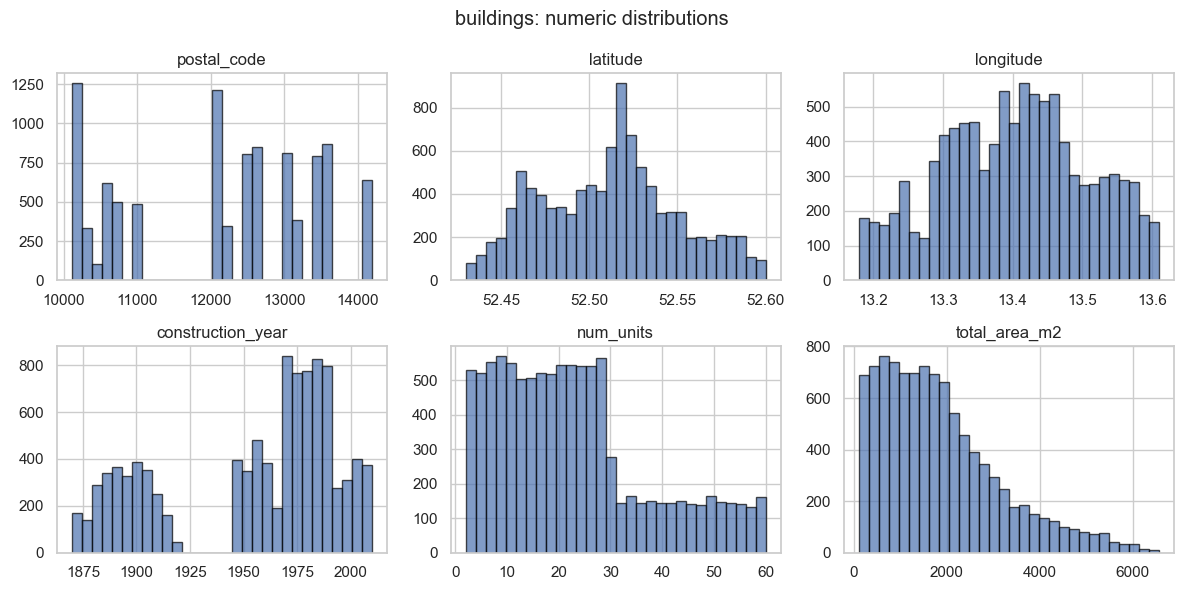

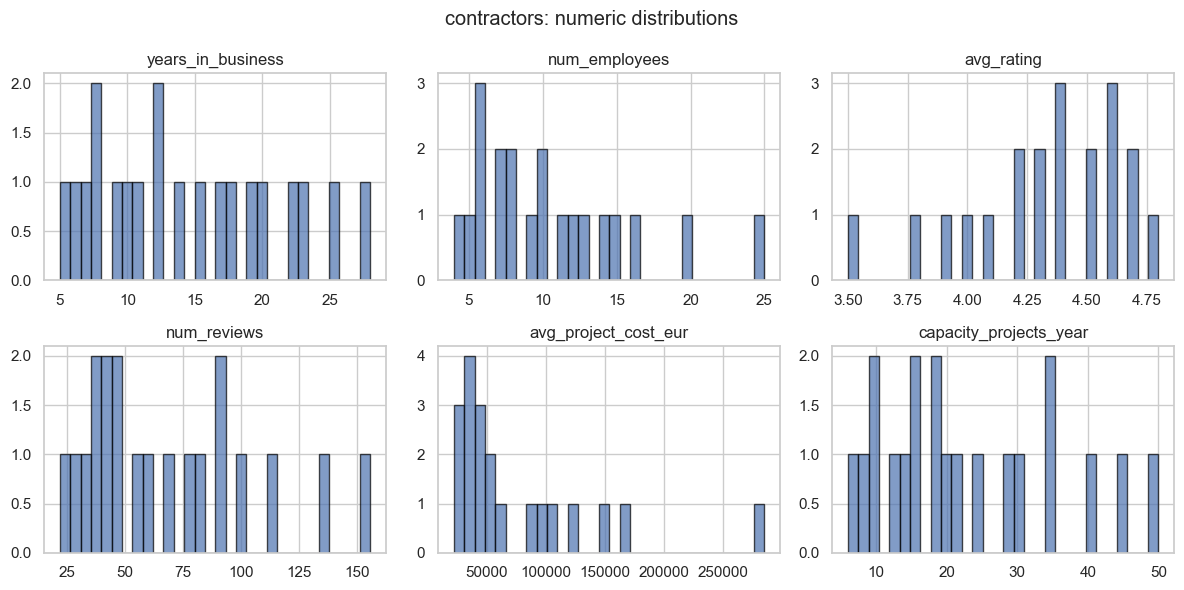

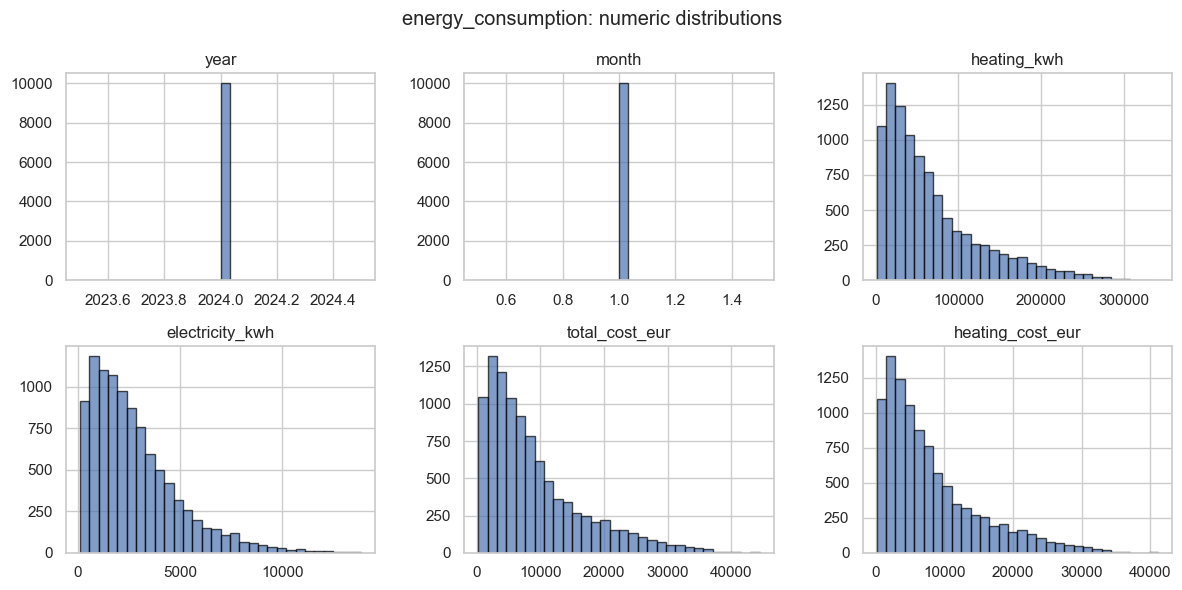

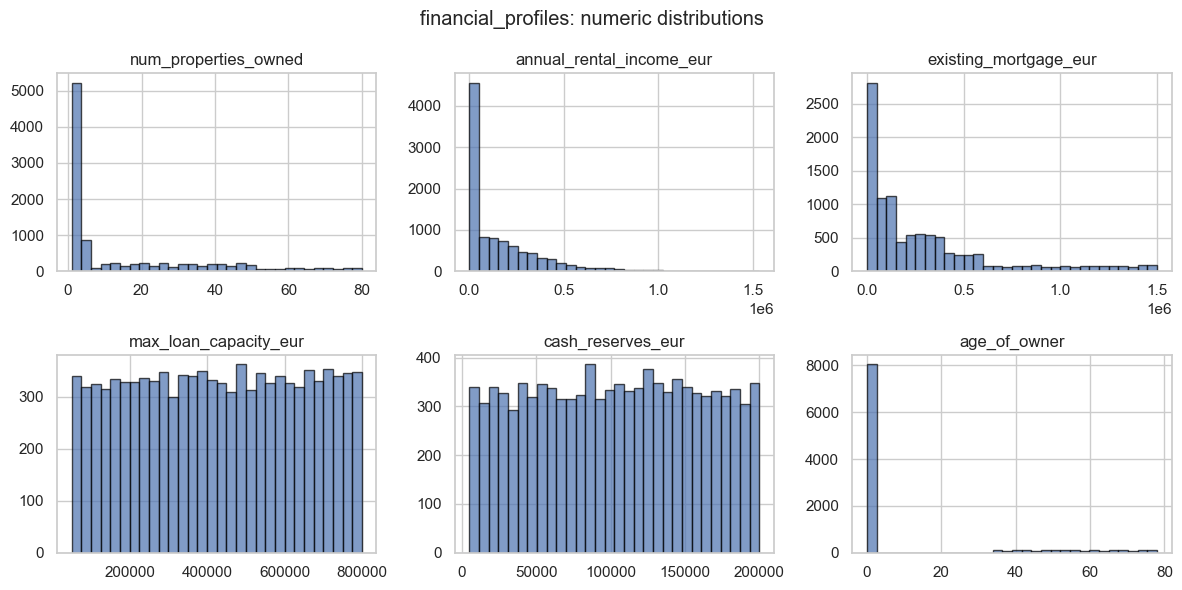

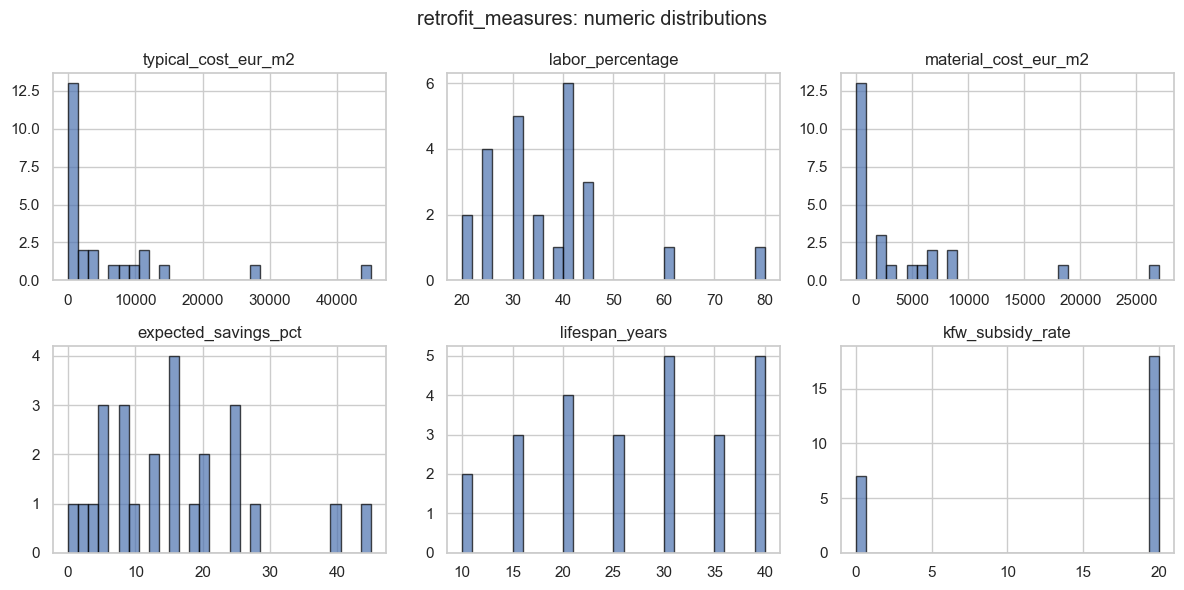

In [5]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme(style="whitegrid")
    for name, df in dfs_cleaned.items():
        numeric = df.select_dtypes(include=["number"])
        if numeric.empty or len(numeric.columns) == 0:
            continue
        cols = numeric.columns[:6].tolist()
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes = axes.flatten()
        for i, col in enumerate(cols):
            axes[i].hist(df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
            axes[i].set_title(col)
        for j in range(len(cols), len(axes)):
            axes[j].set_visible(False)
        fig.suptitle(f"{name}: numeric distributions")
        plt.tight_layout()
        plt.show()
except ImportError:
    print("matplotlib/seaborn not installed; skip plots. Install with: pip install matplotlib seaborn")

In [6]:
saved = []
for name, df in dfs_cleaned.items():
    out_path = DATA_DIR / f"{name}{OUT_SUFFIX}.csv"
    df.to_csv(out_path, index=False)
    saved.append(str(out_path))
    print(f"Saved: {out_path} ({len(df)} rows)")
print(f"\nDone. {len(saved)} files written.")

Saved: ../data/buildings_cleaned.csv (10000 rows)
Saved: ../data/contractors_cleaned.csv (20 rows)
Saved: ../data/energy_consumption_cleaned.csv (10000 rows)
Saved: ../data/financial_profiles_cleaned.csv (10000 rows)
Saved: ../data/retrofit_measures_cleaned.csv (25 rows)

Done. 5 files written.
